In [99]:
# Import Library
import pandas as pd
import numpy as np

# Import dari gdrive
from google.colab import drive
drive.mount('/content/drive')

# Import Regular Expression
import re

# Import Cohen Kappa
from sklearn.metrics import cohen_kappa_score

from sklearn.metrics import precision_score, recall_score, f1_score

#Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# Load ke file CSV di Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/ets/korpus_mentah_new.csv'

# Coba dengan encoding ISO-8859-1
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Tampilkan 5 baris pertama
df.head()


,id_berita,id_judul,teks_kalimat,id_kalimat,f1_lead,f2_judul_sim,f3_freq_word,f4_sim_sent,f5_len_norm,f6_overlap,Label_A1,Label_A2,Label_Final
0,001_beritabali,Boot PLN ring PKB Kaserbu Pengunjung,Siosan ring nonton balih-balihan lan ngarauhin...,0,1,1,1,1,0,1,1,1,1
1,001_beritabali,Boot PLN ring PKB Kaserbu Pengunjung,PLN nglaksanayang interaksi lan transaksi pela...,1,1,1,1,1,1,1,1,1,1
2,001_beritabali,Boot PLN ring PKB Kaserbu Pengunjung,Makudang-kudang layanan sane katurang olih PLN...,2,1,1,1,1,0,1,1,1,1
3,001_beritabali,Boot PLN ring PKB Kaserbu Pengunjung,"Salamin ngawentenang booth layanan puniki, PLN...",3,1,1,1,1,1,1,0,0,0
4,001_beritabali,Boot PLN ring PKB Kaserbu Pengunjung,Mangdane sida malih naut uratian ring booth in...,4,1,1,1,1,0,1,0,0,0


In [60]:
#Cek info awal
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612 entries, 0 to 1611
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_berita     1612 non-null   object
 1   id_judul      1612 non-null   object
 2   teks_kalimat  1612 non-null   object
 3   id_kalimat    1612 non-null   int64 
 4   f1_lead       1612 non-null   int64 
 5   f2_judul_sim  1612 non-null   int64 
 6   f3_freq_word  1612 non-null   int64 
 7   f4_sim_sent   1612 non-null   int64 
 8   f5_len_norm   1612 non-null   int64 
 9   f6_overlap    1612 non-null   int64 
 10  Label_A1      1612 non-null   int64 
 11  Label_A2      1612 non-null   int64 
 12  Label_Final   1612 non-null   int64 
dtypes: int64(10), object(3)
memory usage: 163.8+ KB
None
             id_berita                                   id_judul  \
count             1612                                       1612   
unique             100                                        226  

In [72]:
# Mengecek kualitas DataFrame termasuk: Missing values; Duplikasi baris; Karakter encoding rusak di kolom teks tertentu, Karakter newline (\n dan \r) dari kolom teks pada DataFrame.
def cek_kualitas_data(df, kolom_teks='teks_kalimat'):

    hasil = {}

    # 1. Missing Values
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Missing Values': missing,
        'Percent': missing_percent
    }).sort_values(by='Missing Values', ascending=False)

    hasil['missing_summary'] = missing_summary[missing_summary['Missing Values'] > 0]

    # 2. Duplicate Rows
    duplicate_rows = df.duplicated()
    jumlah_duplikat = duplicate_rows.sum()
    baris_duplikat = df[duplicate_rows]

    print(f"Jumlah baris duplikat: {jumlah_duplikat}")
    hasil['jumlah_duplikat'] = jumlah_duplikat
    hasil['baris_duplikat'] = baris_duplikat

    # 3. Karakter Rusak
    pattern = r'[�ðêéèêëâäîïñôöàÁáÃãÃ‡ÃªÃ¢Ã§]'
    mask = df[kolom_teks].str.contains(pattern, na=False)
    baris_rusak = df[mask]

    jumlah_rusak = len(baris_rusak)
    hasil['jumlah_karakter_rusak'] = jumlah_rusak
    hasil['baris_karakter_rusak'] = baris_rusak[[kolom_teks]]

    print(f"Total baris rusak pada kolom '{kolom_teks}': {jumlah_rusak}")

    # 4. Karakter newline (\n dan \r)
    mask_newline = df[kolom_teks].str.contains(r'[\n\r]', regex=True, na=False)
    baris_newline = df[mask_newline]

    jumlah_newline = len(baris_newline)
    hasil['jumlah_newline'] = jumlah_newline
    hasil['baris_newline'] = baris_newline[[kolom_teks]]

    print(f"Total baris mengandung newline di kolom '{kolom_teks}': {jumlah_newline}")

    return hasil



In [73]:
hasil_cek = cek_kualitas_data(df)

print("\n=== HASIL PEMERIKSAAN KUALITAS DATA ===")

# 1. Missing Values
print("\n# 1. Missing Values")
if hasil_cek['missing_summary'].empty:
    print("Tidak ada missing values.")
else:
    print("Kolom dengan missing values:")
    print(hasil_cek['missing_summary'])

# 2. Duplicate Rows
print("\n# 2. Duplicate Rows")
print(f"Jumlah baris duplikat: {hasil_cek['jumlah_duplikat']}")
if hasil_cek['jumlah_duplikat'] > 0:
    print("Contoh duplikat:")
    print(hasil_cek['baris_duplikat'].head())

# 3. Karakter Rusak
print("\n# 3. Karakter Rusak")
print(f"Jumlah baris dengan karakter rusak: {hasil_cek['jumlah_karakter_rusak']}")
if hasil_cek['jumlah_karakter_rusak'] > 0:
    print("Contoh baris yang mengandung karakter rusak:")
    print(hasil_cek['baris_karakter_rusak'].head())

# 4. Karakter Newline
print("\n# 4. Karakter Newline (\\n dan \\r)")
print(f"Jumlah baris dengan karakter newline: {hasil_cek['jumlah_newline']}")
if hasil_cek['jumlah_newline'] > 0:
    print("Contoh baris yang mengandung newline:")
    print(hasil_cek['baris_newline'].head())


Jumlah baris duplikat: 0
Total baris rusak pada kolom 'teks_kalimat': 0
Total baris mengandung newline di kolom 'teks_kalimat': 0

=== HASIL PEMERIKSAAN KUALITAS DATA ===

# 1. Missing Values
Tidak ada missing values.

# 2. Duplicate Rows
Jumlah baris duplikat: 0

# 3. Karakter Rusak
Jumlah baris dengan karakter rusak: 0

# 4. Karakter Newline (\n dan \r)
Jumlah baris dengan karakter newline: 0


In [74]:
# Terapkan fungsi perbaikan karakter rusak
df = perbaiki_karakter_rusak(df)
print("Karakter rusak telah diperbaiki.")

Karakter rusak telah diperbaiki.


In [75]:
# Cek ulang apakah masih ada karakter rusak setelah perbaikan
# Use the same comprehensive pattern as the initial check for consistency
pattern_recheck = r'[ðêéèêëâäîïñôöàÁáÃãÃ‡ÃªÃ¢Ã§]'
mask_recheck = df['teks_kalimat'].str.contains(pattern_recheck, na=False)
jumlah_rusak_setelah_perbaikan = len(df[mask_recheck])
print(f"Jumlah baris yang masih mengandung karakter rusak setelah perbaikan: {jumlah_rusak_setelah_perbaikan}")

Jumlah baris yang masih mengandung karakter rusak setelah perbaikan: 0


In [76]:
# Memperbaiki karakter encoding rusak.
def perbaiki_karakter_rusak(df, kolom='teks_kalimat'):
    # Pattern to identify the problematic characters as detected earlier
    # This pattern includes characters like , ð, ê, é, è, ë, â, ä, î, ï, ñ, ô, ö, à, Á, á, Ã, ã, Ã‡, Ãª, Ã¢, Ã§
    # We will replace these with an empty string to remove them.
    pattern_to_remove = r'[ðêéèêëâäîïñôöàÁáÃãÃ‡ÃªÃ¢Ã§]'

    # Apply the replacement
    df[kolom] = df[kolom].str.replace(pattern_to_remove, '', regex=True)

    # Note: The previous mapping for 'Ã©' etc. is for a different type of encoding issue.
    # Since the file was read as ISO-8859-1, those specific 'mojibake' sequences are less likely to be the current problem.
    # We are now targeting the explicitly identified 'rusak' characters.

    return df

In [78]:
# Simpan DataFrame ke file CSV dengan encoding UTF-8-SIG dan baca ulang file tersebut.
def simpan_dan_baca_ulang(df, path_csv):

    # Simpan ke CSV
    df.to_csv(path_csv, index=False, encoding='utf-8-sig')
    print(f"File berhasil disimpan ke: {path_csv}")

    # Baca ulang CSV
    df_baru = pd.read_csv(path_csv, encoding='utf-8-sig')
    print("File berhasil dibaca ulang.\n")

    return df_baru

# Tampilkan 5 baris pertama
df_cleaned = simpan_dan_baca_csv(df, file_path)
print(df_cleaned.head())

File disimpan ke: /content/drive/MyDrive/Colab Notebooks/ets/korpus_mentah_new.csv
File berhasil dibaca ulang.
        id_berita                              id_judul  \
0  001_beritabali  Boot PLN ring PKB Kaserbu Pengunjung   
1  001_beritabali  Boot PLN ring PKB Kaserbu Pengunjung   
2  001_beritabali  Boot PLN ring PKB Kaserbu Pengunjung   
3  001_beritabali  Boot PLN ring PKB Kaserbu Pengunjung   
4  001_beritabali  Boot PLN ring PKB Kaserbu Pengunjung   

                                        teks_kalimat  id_kalimat  f1_lead  \
0  Siosan ring nonton balih-balihan lan ngarauhin...           0        1   
1  PLN nglaksanayang interaksi lan transaksi pela...           1        1   
2  Makudang-kudang layanan sane katurang olih PLN...           2        1   
3  Salamin ngawentenang booth layanan puniki, PLN...           3        1   
4  Mangdane sida malih naut uratian ring booth in...           4        1   

   f2_judul_sim  f3_freq_word  f4_sim_sent  f5_len_norm  f6_overlap  La

In [79]:
# Statistik karakteristik teks
def hitung_karakteristik_teks_asli(df, kolom_id='id_berita', kolom_teks='teks_kalimat'):
    # --- Jumlah teks & baris ---
    jumlah_artikel = df[kolom_id].nunique()
    jumlah_kalimat_total = len(df)

    # --- Jumlah kata per kalimat ---
    # Avoid modifying the original df inside the function if it's not intended
    # Create a temporary column for calculation if needed, or perform operations directly
    jumlah_kata_per_kalimat_series = df[kolom_teks].apply(lambda x: len(str(x).split()))
    rata_kata_per_kalimat = jumlah_kata_per_kalimat_series.mean()

    # --- Jumlah kata per teks ---
    kata_per_teks_series = df.groupby(kolom_id)[kolom_teks].apply(lambda x: ' '.join(x).split())
    jumlah_kata_per_teks_df = kata_per_teks_series.apply(len).reset_index(name='jumlah_kata_per_teks')
    rata_kata_per_teks = jumlah_kata_per_teks_df['jumlah_kata_per_teks'].mean()
    total_kata_dataset = jumlah_kata_per_teks_df['jumlah_kata_per_teks'].sum()

    # --- Jumlah karakter per teks ---
    jumlah_karakter_per_kalimat_series = df[kolom_teks].apply(lambda x: len(str(x)))
    karakter_per_teks_df = df.groupby(kolom_id)[kolom_teks].apply(lambda x: len(' '.join(x))).reset_index(name='jumlah_karakter_per_teks')
    rata_karakter_per_teks = karakter_per_teks_df['jumlah_karakter_per_teks'].mean()
    total_karakter_dataset = karakter_per_teks_df['jumlah_karakter_per_teks'].sum()

    # --- Distribusi panjang kalimat per teks (min, max, rata-rata) ---
    kalimat_per_teks_count = df.groupby(kolom_id).size().reset_index(name='jumlah_kalimat')
    min_kalimat = kalimat_per_teks_count['jumlah_kalimat'].min()
    max_kalimat = kalimat_per_teks_count['jumlah_kalimat'].max()

    # --- Distribusi Label_Final ---
    distribusi_label = df['Label_Final'].value_counts()
    distribusi_label_str = []
    for label, count in distribusi_label.items():
        percentage = count / jumlah_kalimat_total * 100
        distribusi_label_str.append(f'Label {label}: {count} ({percentage:.2f}%)')
    distribusi_label_formatted = ', '.join(distribusi_label_str)


    # --- Buat Tabel Ringkasan ---
    ringkasan = pd.DataFrame({
        'Karakteristik Teks Asli': [
            'Jumlah teks asli (artikel)',
            'Jumlah baris (kalimat)',
            'Total kata dalam seluruh dataset',
            'Total karakter dalam seluruh dataset',
            'Rata-rata kata per kalimat',
            'Rata-rata kata per teks',
            'Rata-rata karakter per teks',
            'Distribusi jumlah kalimat per teks (min–max)',
            'Distribusi Label_Final' # New entry
        ],
        'Nilai': [
            f'{jumlah_artikel} artikel',
            f'{jumlah_kalimat_total} kalimat',
            f'{total_kata_dataset:,} kata',
            f'{total_karakter_dataset:,} karakter',
            f'{rata_kata_per_kalimat:.2f} kata',
            f'{rata_kata_per_teks:.2f} kata',
            f'{rata_karakter_per_teks:.2f} karakter',
            f'{min_kalimat} – {max_kalimat} kalimat',
            distribusi_label_formatted # New entry
        ]
    })

    return ringkasan

In [51]:
# Tampilkan hasil
hasil_tabel = hitung_karakteristik_teks_asli(df)
display(hasil_tabel)

,Karakteristik Teks Asli,Nilai
0,Jumlah teks asli (artikel),100 artikel
1,Jumlah baris (kalimat),1612 kalimat
2,Total kata dalam seluruh dataset,"38,271 kata"
3,Total karakter dalam seluruh dataset,"289,988 karakter"
4,Rata-rata kata per kalimat,23.74 kata
5,Rata-rata kata per teks,382.71 kata
6,Rata-rata karakter per teks,2899.88 karakter
7,Distribusi jumlah kalimat per teks (min–max),10 – 32 kalimat
8,Distribusi Label_Final,"Label 0: 889 (55.15%), Label 1: 723 (44.85%)"


In [80]:
# Hitung Cohen's Kappa
kappa = cohen_kappa_score(df['Label_A1'], df['Label_A2'])
print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 1.00


In [117]:
# Analisis Distribusi Compression Ratio (CR) Aktual dan Label Anotasi kalimat penting (0/1) berdasarkan Label_Final

def analyze_cr_distribution(df_summary, original_df):
    # Hitung Compression Ratio (CR) aktual per berita
    df_summary['CR_aktual'] = df_summary['kalimat_penting'] / df_summary['total_kalimat']

    # Statistik deskriptif CR
    mean_CR = df_summary['CR_aktual'].mean()
    median_CR = df_summary['CR_aktual'].median()
    skewness = stats.skew(df_summary['CR_aktual'])

    print("Statistik Dasar Compression Ratio (CR):")
    print(f"   Rata-rata CR (mean): {mean_CR:.3f}")
    print(f"   Median CR: {median_CR:.3f}")
    print(f"   Skewness (kemiringan distribusi): {skewness:.3f}\n")

    # Visualisasi Kurva Distribusi (KDE) dengan Garis Mean, Median & Skewness
    plt.figure(figsize=(8,5))
    sns.kdeplot(df_summary['CR_aktual'], fill=True, color='skyblue', alpha=0.7)

    plt.axvline(mean_CR, color='green', linestyle='--', linewidth=2, label=f'Mean = {mean_CR:.2f}')
    plt.axvline(median_CR, color='red', linestyle='--', linewidth=2, label=f'Median = {median_CR:.2f}')

    if skewness > 0:
        skew_text = "Distribusi condong ke kanan (positif)"
        skew_color = "blue"
    elif skewness < 0:
        skew_text = "Distribusi condong ke kiri (negatif)"
        skew_color = "orange"
    else:
        skew_text = "Distribusi simetris"
        skew_color = "gray"

    plt.text(0.12, plt.ylim()[1]*0.9, # Adjust y position as KDE height might vary
             f"Skewness = {skewness:.2f}\n{skew_text}",
             color=skew_color, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.7))

    plt.title('Kurva Distribusi Compression Ratio (CR) Aktual per Berita')
    plt.xlabel('CR Aktual')
    plt.ylabel('Densitas')
    # plt.xticks(bins) # Bins are not applicable for KDE
    plt.legend()
    plt.show()

    # Boxplot untuk Deteksi Outlier
    plt.figure(figsize=(7,2))
    plt.boxplot(df_summary['CR_aktual'], vert=False, patch_artist=True)
    plt.title('Boxplot Compression Ratio (CR) Aktual')
    plt.xlabel('CR Aktual')
    plt.show()

    # Uji Normalitas (Shapiro–Wilk)
    stat, p = stats.shapiro(df_summary['CR_aktual'])
    print(f"Uji Shapiro-Wilk: Statistik={stat:.3f}, p-value={p:.3f}")

    if p > 0.05:
        print("Data berdistribusi normal → gunakan MEAN CR")
    else:
        print("Data tidak normal → gunakan MEDIAN CR")

    # Interpretasi Skewness
    if skewness > 0.5:
        print("Skewness positif kuat → data condong ke kanan (gunakan MEDIAN CR)")
    elif skewness < -0.5:
        print("Skewness negatif kuat → data condong ke kiri (gunakan MEDIAN CR)")
    else:
        print("Skewness mendekati 0 → data relatif simetris (gunakan MEAN CR)")

    # Distribusi Label Kalimat Penting (berdasarkan Label_Final) from original_df
    print("\n Distribusi Label Kalimat Penting (berdasarkan Label_Final):")

    label_counts = original_df['Label_Final'].value_counts().sort_index()

    # Visualisasi distribusi label
    plt.figure(figsize=(5,3))
    plt.bar(label_counts.index, label_counts.values, color=['gray', 'orange'])
    plt.xticks([0, 1], ['Tidak Penting (0)', 'Penting (1)'])
    plt.title('Distribusi Label Kalimat Penting (Label_Final)')
    plt.ylabel('Jumlah Kalimat')
    plt.show()

    print(label_counts)
    print("\n Interpretasi: Proporsi label membantu memahami keseimbangan data untuk pelatihan model.\n")

    # Rekomendasi CR Threshold Otomatis
    if p > 0.05 and abs(skewness) < 0.5:
        cr_threshold = round(mean_CR, 2)
        rekomendasi = "Mean CR (data normal & simetris)"
    else:
        cr_threshold = round(median_CR, 2)
        rekomendasi = "Median CR (data tidak normal atau miring)"

    print(f"Rekomendasi Threshold CR Optimal: {cr_threshold} ({rekomendasi})")

    return cr_threshold

Statistik Dasar Compression Ratio (CR):
   Rata-rata CR (mean): 0.459
   Median CR: 0.447
   Skewness (kemiringan distribusi): 0.599



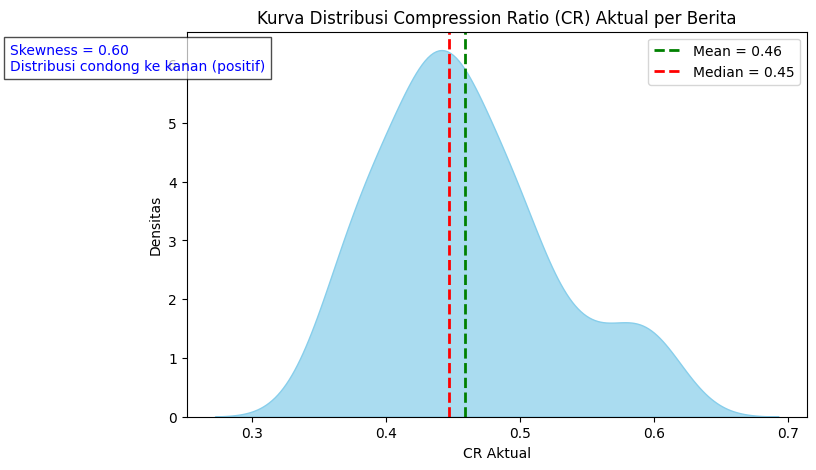

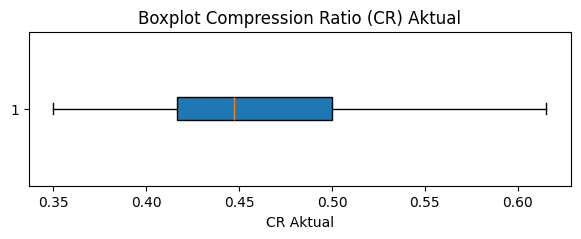

Uji Shapiro-Wilk: Statistik=0.950, p-value=0.001
Data tidak normal → gunakan MEDIAN CR
Skewness positif kuat → data condong ke kanan (gunakan MEDIAN CR)

 Distribusi Label Kalimat Penting (berdasarkan Label_Final):


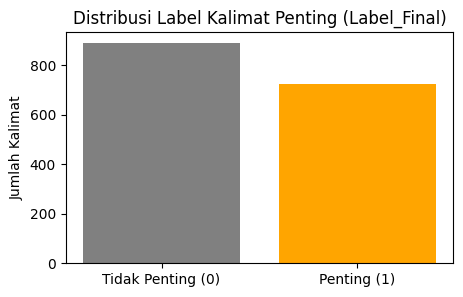

Label_Final
0    889
1    723
Name: count, dtype: int64

 Interpretasi: Proporsi label membantu memahami keseimbangan data untuk pelatihan model.

Rekomendasi Threshold CR Optimal: 0.45 (Median CR (data tidak normal atau miring))


In [118]:
# Jalankan fungsi analisis
cr_optimal = analyze_cr_distribution(df_summary, df)

In [112]:
# Tentukan batas maksimum CR
CR = 0.45  # batas CR yang sudah kamu tentukan

# Seleksi kalimat berdasarkan batas CR
ringkasan = []

# Kelompokkan berdasarkan id_berita
for id_berita, group in df.groupby('id_berita'):
    # Total kalimat dalam berita
    total_kalimat = len(group)

    # Hitung berapa kalimat maksimum yang boleh diambil
    top_n = int(round(total_kalimat * CR))

    # Ambil kalimat penting saja (Label_Final = 1)
    penting = group[group['Label_Final'] == 1].copy()

    # === Solusi Perbaikan: Ranking Kalimat Penting ===
    # Jika jumlah kalimat penting lebih dari batas CR, kita perlu memilih yang 'paling' penting
    if len(penting) > top_n:
        # Buat skor kepentingan sementara dengan menjumlahkan fitur-fitur yang ada
        # Anda bisa menyesuaikan bobot atau cara kombinasi fitur sesuai kebutuhan
        penting['importance_score'] = penting[['f1_lead', 'f2_judul_sim', 'f3_freq_word', 'f4_sim_sent', 'f5_len_norm', 'f6_overlap']].sum(axis=1)

        # Urutkan berdasarkan skor kepentingan dan ambil top_n
        penting = penting.sort_values(by='importance_score', ascending=False).head(top_n)

    # Hapus kolom sementara 'importance_score' jika ada
    if 'importance_score' in penting.columns:
        penting = penting.drop(columns=['importance_score'])
    # ==================================================

    # Simpan hasil ringkasan
    ringkasan.append(penting)

# Gabungkan semua hasil ringkasan
df_ringkasan_manual = pd.concat(ringkasan)

# Tampilkan hasil ringkasan manual untuk 5 berita pertama ---
print("Hasil Ringkasan Manual (5 Berita Pertama):")
for i, (id_berita, group_df) in enumerate(df_ringkasan_manual.groupby('id_berita')):
    if i >= 5: # Limit to the first 5 articles
        break
    print(f"\nID Berita: {id_berita}")
    for teks in group_df['teks_kalimat']:
        print(f"- {teks}")

Hasil Ringkasan Manual (5 Berita Pertama):

ID Berita: 001_beritabali
- Siosan ring nonton balih-balihan lan ngarauhin stand kuliner ring Pesta Kesenian Bali (PKB), nenten ja rauh akedik kramane ngarauhin fasilitas boot sane sampun kasayagayang olih PT PLN (Persero) Unit Induk Distribusi (UID) Bali. 
- PLN nglaksanayang interaksi lan transaksi pelanggan nincap salami pamargin Pesta Kesenian Bali (PKB) ka ping-47 sampun karauhin antuk panyatusan krama sane saking makudang genah. 
- Makudang-kudang layanan sane katurang olih PLN dahat kamiletin olih para kramane, minakadi numbas token listrik, permohonan perubahan daya, pengunduhan aplikasi PLN Mobile, saha ngawewehin antuk nguningayang indik layanan internet Iconnet lan produk-produk berbasis energi bersih. 
- Pengunjung taler kapicayang galah natasang malih indik sane kabaos transisienergi saha gaya hidup Electrifying Lifestyle, inggih punika pola hidup modern nganggen sakancan piranti mawiwit saking listrik ramah lingkungan, minakadi 

In [113]:
# Pilih kolom yang ingin disimpan
df_ringkasan_manual = df_ringkasan_manual[['id_berita', 'teks_kalimat', 'id_kalimat', 'Label_Final']]

# Simpan ke file CSV (encoding ISO-8859-1)
file_path = '/content/drive/MyDrive/Colab Notebooks/ets/ringkas_manual.csv'
df_ringkasan_manual.to_csv(file_path, index=False, encoding='ISO-8859-1')

print(f"Hasil ringkasan manual berhasil disimpan ke: {file_path}")
print(f"Total kalimat ringkasan yang tersimpan: {len(df_ringkasan_manual)}")

Hasil ringkasan manual berhasil disimpan ke: /content/drive/MyDrive/Colab Notebooks/ets/ringkas_manual.csv
Total kalimat ringkasan yang tersimpan: 680


In [120]:
# Evaluasi Ringkasan Manual: mengukur performa dari sebuah model klasifikasi
# (mengklasifikasikan kalimat sebagai 'penting' (masuk ringkasan) atau 'tidak penting' (tidak masuk ringkasan).)

# Buat ID unik gabungan untuk setiap kalimat di df asli
df['unique_sentence_id'] = df['id_berita'].astype(str) + '_' + df['id_kalimat'].astype(str)

# Buat ID unik gabungan untuk setiap kalimat di df_ringkasan_manual
df_ringkasan_manual['unique_sentence_id'] = df_ringkasan_manual['id_berita'].astype(str) + '_' + df_ringkasan_manual['id_kalimat'].astype(str)

# y_true adalah Label_Final dari df asli
y_true = df['Label_Final']

# y_pred menunjukkan apakah kalimat dari df asli ada di df_ringkasan_manual berdasarkan unique_sentence_id
y_pred = df['unique_sentence_id'].isin(df_ringkasan_manual['unique_sentence_id']).astype(int)

from sklearn.metrics import accuracy_score

print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))

Precision: 1.0
Recall: 0.9405255878284924
F1 Score: 0.9693513898788311
Accuracy: 0.9733250620347395
